# Repeated measures Bland-Altman

#### Import modules

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import pingouin as pg

In [2]:
file_path = 'pixel_hr_stacked.xlsx'
df = pd.read_excel(file_path)

In [3]:
df = df.loc[:, ['participant_id', 'timestamp', 'polar_hr', 'pixel_hr']]

In [4]:
df.head()

,participant_id,timestamp,polar_hr,pixel_hr
0,1,12:02:17,91,84
1,1,12:02:20,85,84
2,1,12:02:23,93,89
3,1,12:02:25,102,93
4,1,12:02:27,102,92


In [5]:
df.shape

(11826, 4)

### Remove participant 28 and 29 for exploratory subgroup analysis, because they were really inaccurate

In [ ]:
# df = df.loc[~df['participant_id'].isin([28, 29])]

In [7]:
df.shape

(10782, 4)

#### Paired differences and means

In [8]:
df['diff'] = df['pixel_hr'] - df['polar_hr']
df['paired_mean_hr'] = df[['polar_hr', 'pixel_hr']].mean(axis=1)

### Run a one-way ANOVA

The difference in mathced pairs is the response

In [9]:
# aov = pg.anova(dv='diff', between='participant_id', data=df, detailed=True)
# print(aov)

In [ ]:
model = ols('diff ~ C(participant_id)', data=df).fit()

In [ ]:
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(participant_id),54409.246841,30.0,84.73588,0.0
Residual,230108.666348,10751.0,NaN,NaN


In [ ]:
ms_between = anova_table['sum_sq'].iloc[0] / anova_table['df'].iloc[0]
ms_within = anova_table['sum_sq'].iloc[1] / anova_table['df'].iloc[1]

#### Divisor k

In [ ]:
counts = df['participant_id'].value_counts()
n = len(counts)
sum_mi = counts.sum()
sum_mi_sq = (counts ** 2).sum()
k = ((sum_mi ** 2) - sum_mi_sq) / ((n - 1) * sum_mi)

#### Variance

In [ ]:
var_between = (ms_between - ms_within) / k
var_within = ms_within
var_total = var_between + var_within

#### Bias and LoA

In [ ]:
bias = df['diff'].mean()
sd_total = np.sqrt(var_total)
loa_lower = bias - 1.96 * sd_total
loa_upper = bias + 1.96 * sd_total

print(f"Bias: {bias:.2f} bpm")
print(f"Within-subject SD: {np.sqrt(var_within):.2f}")
print(f"Between-subject SD: {np.sqrt(var_between):.2f}")
print(f"Total SD: {sd_total:.2f}")
print(f"95% Limits of Agreement: {loa_lower:.2f} to {loa_upper:.2f} bpm")

Bias: -2.01 bpm
Within-subject SD: 4.63
Between-subject SD: 2.27
Total SD: 5.16
95% Limits of Agreement: -12.12 to 8.09 bpm


In [ ]:
n = len(df['diff'])

sem = sd_total / np.sqrt(n)
ci_lower = bias - 1.96 * sem
ci_upper = bias + 1.96 * sem

print(f"Bias: {bias:.2f} (95% CI {ci_lower:.2f} to {ci_upper:.2f})")

Bias: -2.01 (95% CI -2.11 to -1.92)


#### BA plot

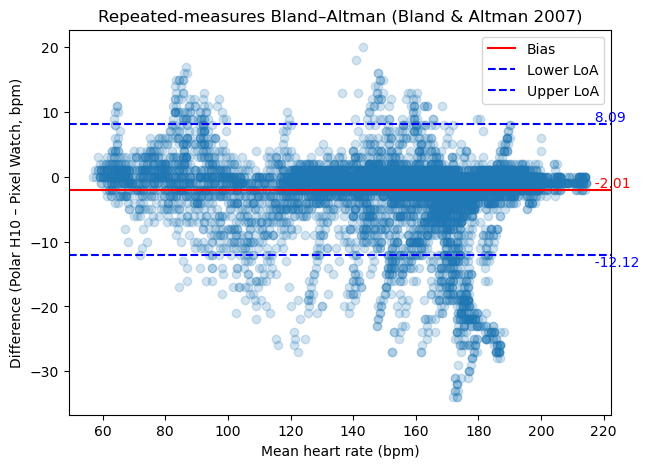

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(df['paired_mean_hr'], df['diff'], alpha=0.2)
plt.axhline(bias, color='red', label='Bias')
plt.axhline(loa_lower, color='blue', linestyle='--', label='Lower LoA')
plt.axhline(loa_upper, color='blue', linestyle='--', label='Upper LoA')

xpos = df['paired_mean_hr'].max()
plt.text(xpos, bias,     f"  {bias:.2f}",     color='red', va='bottom')
plt.text(xpos, loa_upper,f"  {loa_upper:.2f}", color='blue', va='bottom')
plt.text(xpos, loa_lower,f"  {loa_lower:.2f}", color='blue', va='top')

plt.xlabel("Mean heart rate (bpm)")
plt.ylabel("Difference (Polar H10 – Pixel Watch, bpm)")
plt.title("Repeated-measures Bland–Altman (Bland & Altman 2007)")
plt.legend()
plt.show()